Generating enhanced filtering stages visualization...


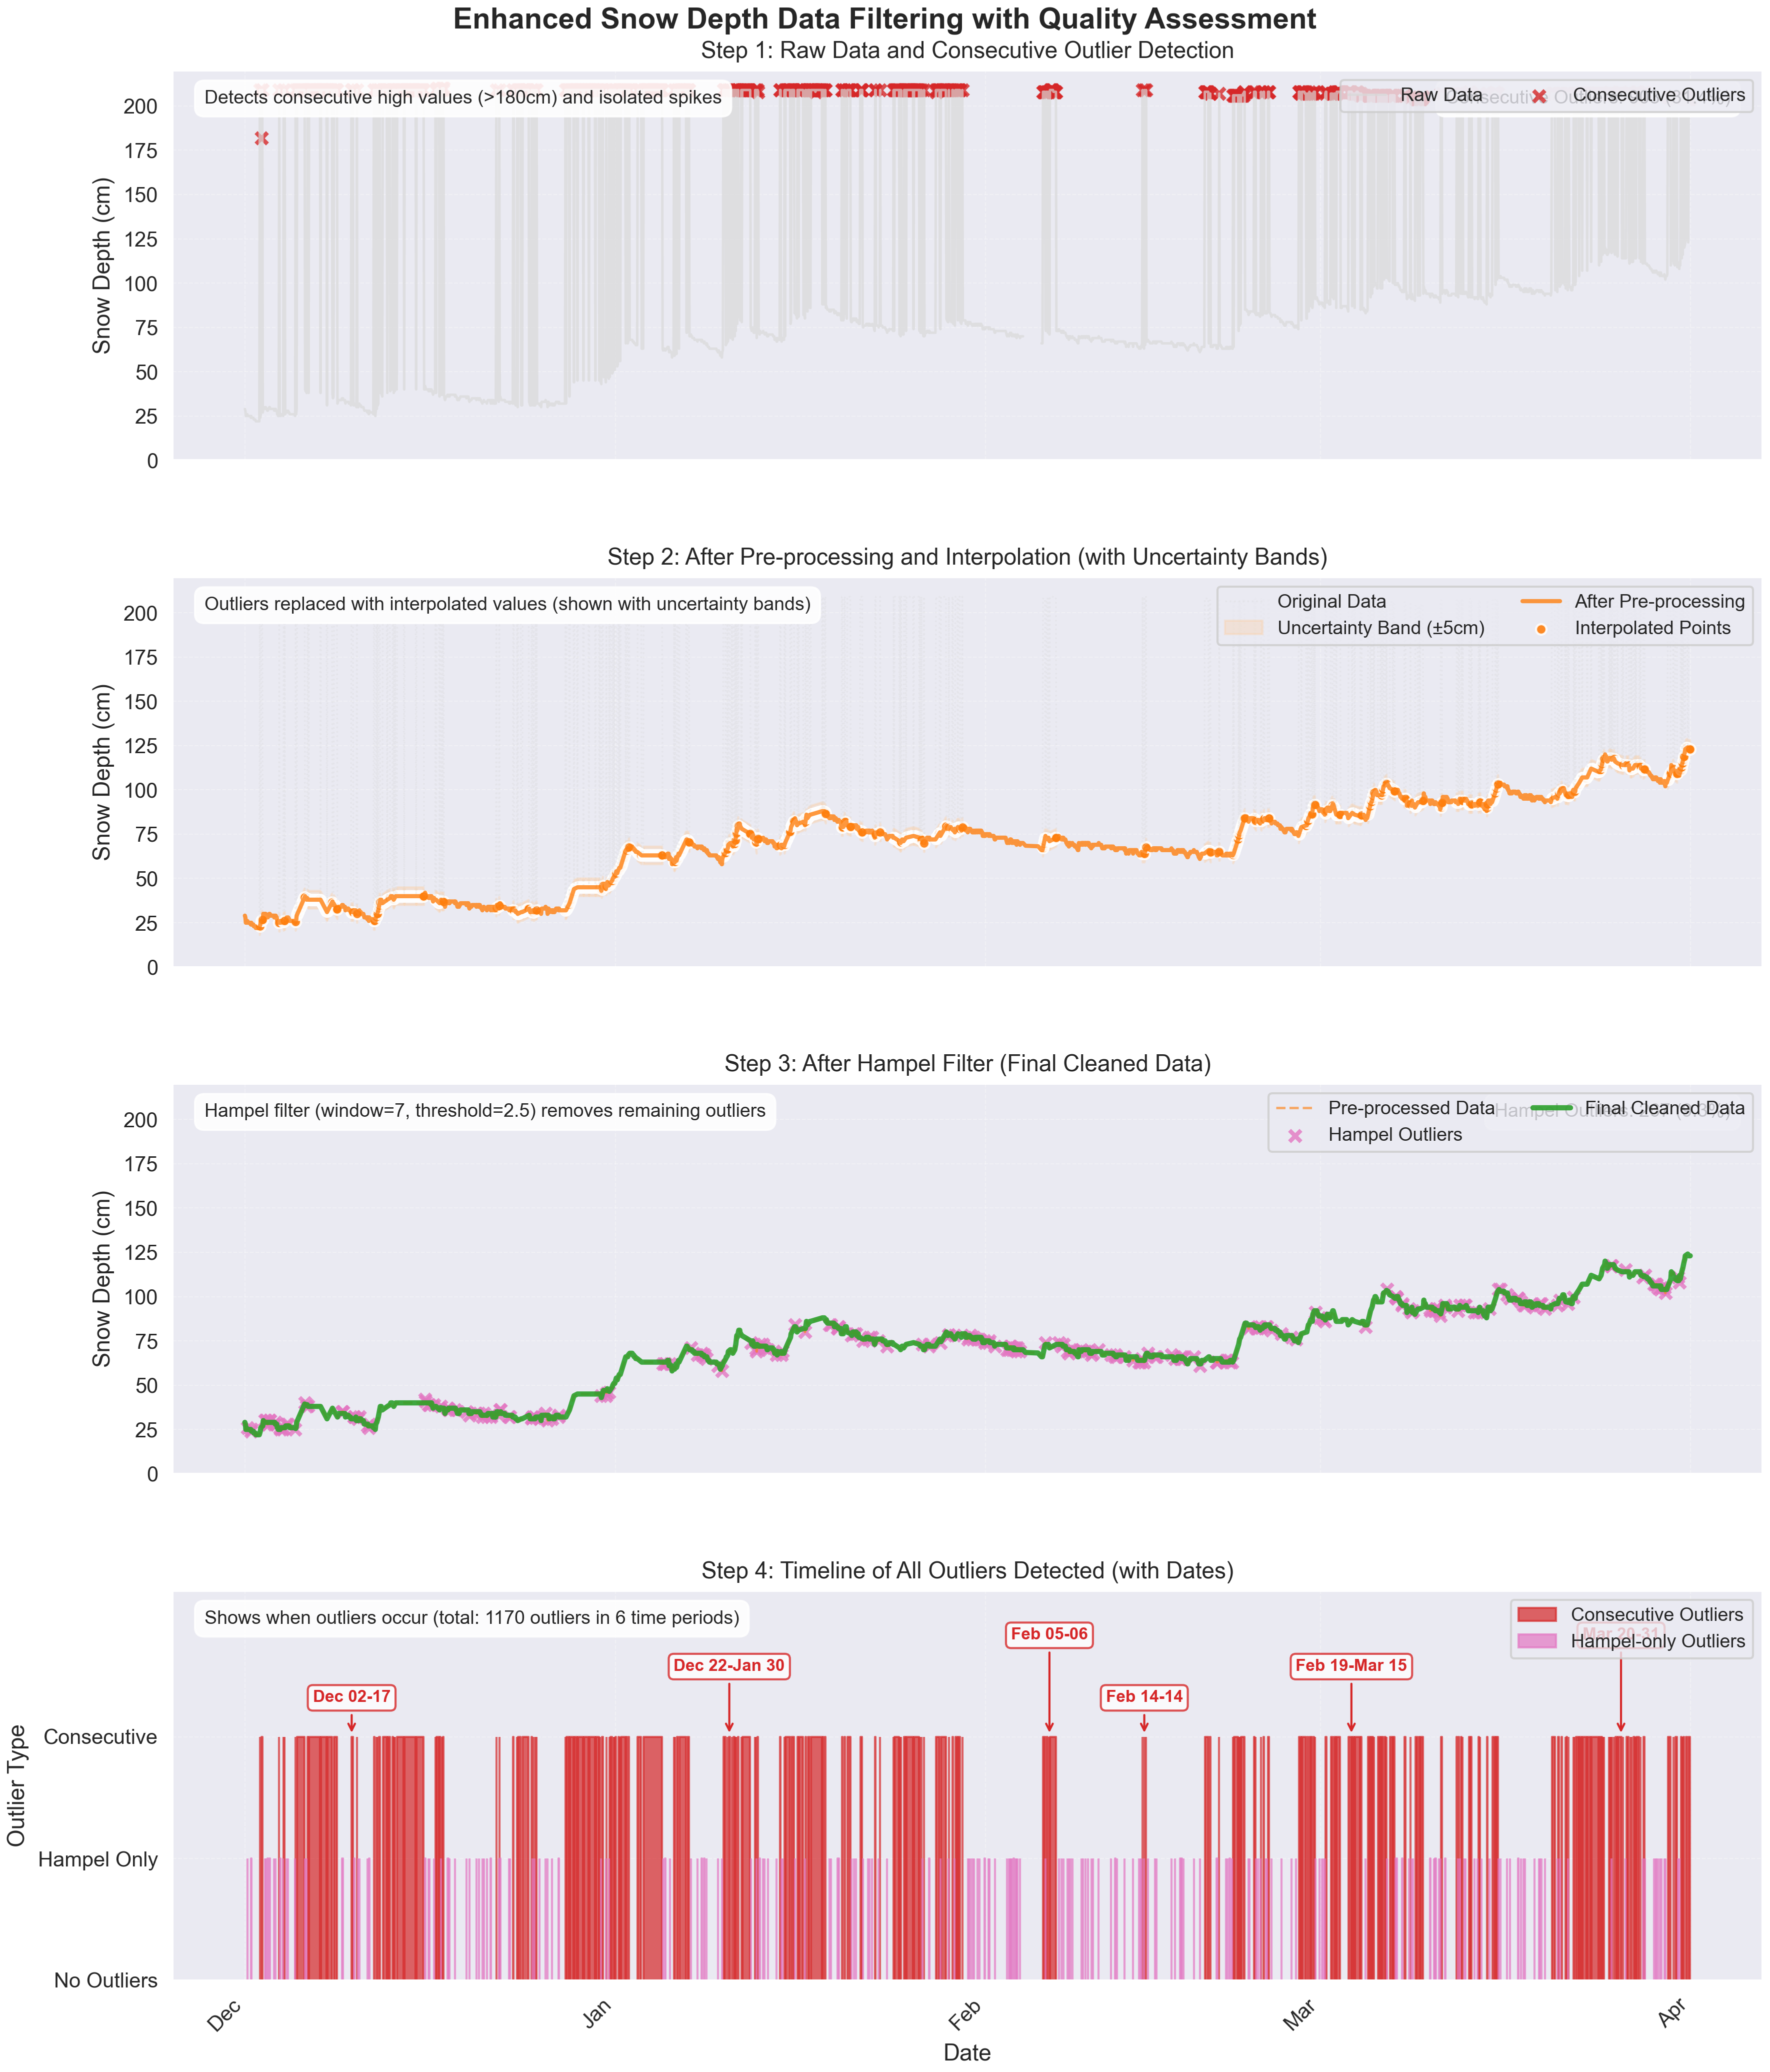

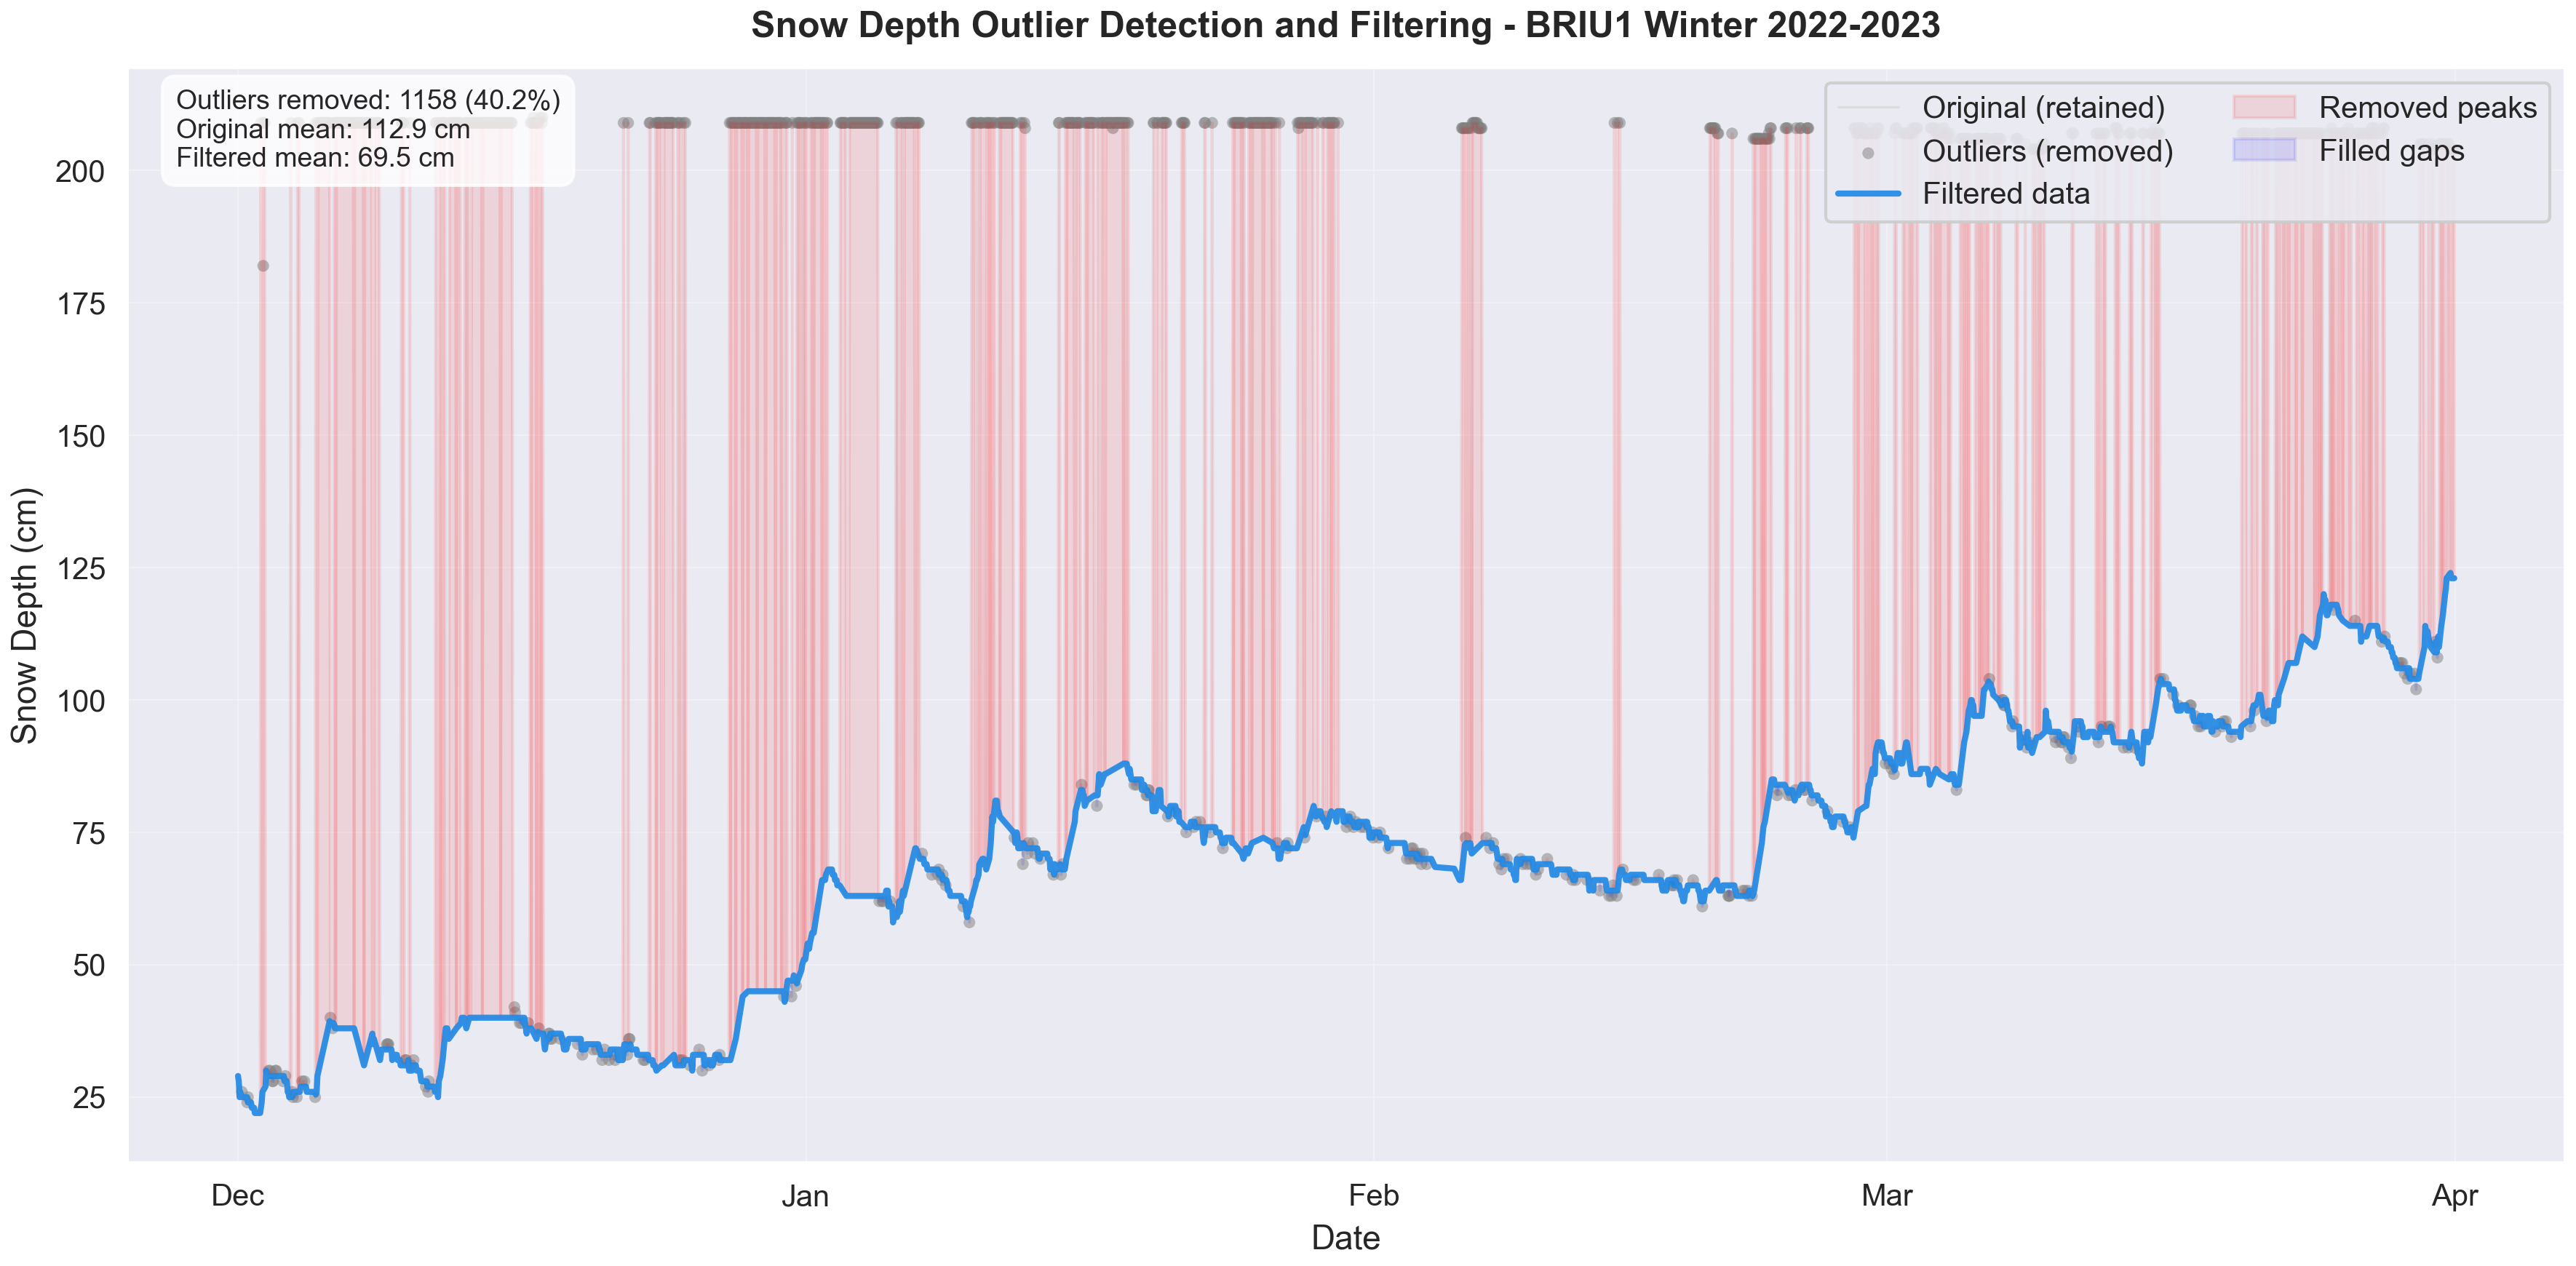

Snow depth filtering and visualization completed successfully!
Generated two visualizations:
1. snow_depth_filtering_stages.png/pdf - Shows the progressive filtering stages
2. snow_depth_filtered_visualization.png/pdf - Shows the final comparison


In [7]:
import polars as pl
import numpy as np
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pandas import Series
from matplotlib.dates import DateFormatter, MonthLocator


def configure_publication_styling():
    """Configure styling for publication quality figures"""
    try:
        import scienceplots
        plt.style.use(['science', 'nature'])
        science_plots_is_available = True
    except ImportError:
        science_plots_is_available = False

    if not science_plots_is_available:
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
        plt.rcParams['font.size'] = 10
        plt.rcParams['axes.linewidth'] = 1
        plt.rcParams['axes.labelsize'] = 11
        plt.rcParams['axes.titlesize'] = 12
        plt.rcParams['xtick.labelsize'] = 10
        plt.rcParams['ytick.labelsize'] = 10
        plt.rcParams['legend.fontsize'] = 10
        plt.rcParams['figure.titlesize'] = 14
        plt.rcParams['figure.dpi'] = 300
        plt.rcParams['savefig.dpi'] = 300
        plt.rcParams['savefig.bbox'] = 'tight'
        plt.rcParams['savefig.pad_inches'] = 0.05
        plt.rcParams['grid.linewidth'] = 0.5
        plt.rcParams['grid.alpha'] = 0.3
        plt.rcParams['figure.figsize'] = (10, 6)


def hampel_filter_function(input_data, window_size=7, threshold=3):
    if window_size % 2 == 0:
        raise ValueError("Window size must be an odd integer.")

    sliding_windows = np.lib.stride_tricks.sliding_window_view(input_data, window_shape=window_size)
    median_values = np.median(sliding_windows, axis=1)

    mad_values = []
    for window in sliding_windows:
        mad_value = median_abs_deviation(window, scale=1.0)
        mad_values.append(mad_value)
    mad_values = np.array(mad_values)

    half_window_size = int(np.floor(window_size / 2))
    center_point_values = input_data[half_window_size:-half_window_size]
    absolute_differences = np.abs(center_point_values - median_values)
    threshold_values = threshold * mad_values
    outlier_boolean_mask = absolute_differences > threshold_values

    result_array = input_data.copy()
    filtered_center_values = np.where(outlier_boolean_mask, median_values, center_point_values)
    result_array[half_window_size:-half_window_size] = filtered_center_values

    outlier_indices = []
    if len(outlier_boolean_mask) > 0:
        for index, is_outlier in enumerate(outlier_boolean_mask):
            if is_outlier:
                outlier_indices.append(index + half_window_size)

    return result_array, outlier_indices


def plot_filtering_stages(data_frame, value_column="value", timestamp_column="date_time",
                          consecutive_outlier_mask=None, hampel_window=7, hampel_threshold=2.5):
    """Create publication-quality visualization showing each filtering stage."""
    print("Generating enhanced filtering stages visualization...")

    original_values = data_frame[value_column].to_numpy()
    timestamps = pd.to_datetime(data_frame[timestamp_column].to_numpy())

    preprocessed_values = original_values.copy()
    interpolated_regions = np.zeros(len(original_values), dtype=bool)

    if consecutive_outlier_mask is not None:
        interpolated_regions = consecutive_outlier_mask.copy()

        for index in range(len(consecutive_outlier_mask)):
            if consecutive_outlier_mask[index]:
                preprocessed_values[index] = np.nan

        preprocessed_series = Series(preprocessed_values)
        interpolated_series = preprocessed_series.interpolate(method='linear', limit_direction='both')
        preprocessed_values = interpolated_series.values

    final_filtered_values, hampel_outlier_indices = hampel_filter_function(
        preprocessed_values, window_size=hampel_window, threshold=hampel_threshold
    )

    fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
    fig.suptitle("Enhanced Snow Depth Data Filtering with Quality Assessment", y=0.99, fontweight='bold', fontsize=14)

    colors = {
        'raw_data': '#d9d9d9',
        'valid_points': '#4c72b0',
        'consecutive_outliers': '#d62728',
        'preprocessed': '#ff7f0e',
        'uncertainty': '#ffcc99',
        'hampel_outliers': '#e377c2',
        'final_filtered': '#2ca02c',
        'outlier_timeline': '#8B0000'
    }

    uncertainty_band_width = 5
    lower_bound = preprocessed_values - uncertainty_band_width
    upper_bound = preprocessed_values + uncertainty_band_width

    ax1 = axes[0]
    ax1.set_title("Step 1: Raw Data and Consecutive Outlier Detection", fontsize=11)
    ax1.plot(timestamps, original_values, color=colors['raw_data'],
             linewidth=1.2, alpha=0.7, label='Raw Data')

    if consecutive_outlier_mask is not None:
        consecutive_outlier_indices = np.where(consecutive_outlier_mask)[0]
        if len(consecutive_outlier_indices) > 0:
            outlier_timestamps = timestamps[consecutive_outlier_indices]
            outlier_values = original_values[consecutive_outlier_indices]

            ax1.scatter(outlier_timestamps, outlier_values,
                        color=colors['consecutive_outliers'], s=30, marker='x',
                        linewidth=2, alpha=0.8, label='Consecutive Outliers')

            outlier_percent = len(consecutive_outlier_indices) / len(original_values) * 100
            ax1.text(0.98, 0.95, f"Consecutive Outliers: {len(consecutive_outlier_indices)} ({outlier_percent:.1f}%)",
                     transform=ax1.transAxes, fontsize=9, verticalalignment='top',
                     horizontalalignment='right',
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

    ax1.text(0.02, 0.95, "Detects consecutive high values (>180cm) and isolated spikes",
             transform=ax1.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

    ax2 = axes[1]
    ax2.set_title("Step 2: After Pre-processing and Interpolation (with Uncertainty Bands)", fontsize=11)
    ax2.plot(timestamps, original_values, color=colors['raw_data'],
             linewidth=0.8, alpha=0.3, linestyle=':', label='Original Data')

    interpolated_mask = interpolated_regions if consecutive_outlier_mask is not None else np.zeros(len(original_values), dtype=bool)
    if np.any(interpolated_mask):
        ax2.fill_between(timestamps, lower_bound, upper_bound,
                         where=interpolated_mask, color=colors['uncertainty'],
                         alpha=0.3, label='Uncertainty Band (±5cm)', interpolate=True)

    ax2.plot(timestamps, preprocessed_values, color=colors['preprocessed'],
             linewidth=2, alpha=0.8, label='After Pre-processing')

    if consecutive_outlier_mask is not None:
        consecutive_outlier_indices = np.where(consecutive_outlier_mask)[0]
        if len(consecutive_outlier_indices) > 0:
            interp_timestamps = timestamps[consecutive_outlier_indices]
            interp_values = preprocessed_values[consecutive_outlier_indices]

            ax2.scatter(interp_timestamps, interp_values,
                        color=colors['preprocessed'], s=25, marker='o',
                        alpha=0.9, label='Interpolated Points',
                        edgecolors='white', linewidth=1)

    ax2.text(0.02, 0.95, "Outliers replaced with interpolated values (shown with uncertainty bands)",
             transform=ax2.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

    ax3 = axes[2]
    ax3.set_title("Step 3: After Hampel Filter (Final Cleaned Data)", fontsize=11)
    ax3.plot(timestamps, preprocessed_values, color=colors['preprocessed'],
             linewidth=1.2, alpha=0.6, linestyle='--', label='Pre-processed Data')

    if len(hampel_outlier_indices) > 0:
        hampel_outlier_timestamps = timestamps[hampel_outlier_indices]
        hampel_outlier_values = preprocessed_values[hampel_outlier_indices]

        ax3.scatter(hampel_outlier_timestamps, hampel_outlier_values,
                    color=colors['hampel_outliers'], s=30, marker='x',
                    linewidth=2, alpha=0.8, label='Hampel Outliers')

        hampel_percent = len(hampel_outlier_indices) / len(original_values) * 100
        ax3.text(0.98, 0.95, f"Hampel Outliers: {len(hampel_outlier_indices)} ({hampel_percent:.1f}%)",
                 transform=ax3.transAxes, fontsize=9, verticalalignment='top',
                 horizontalalignment='right',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

    ax3.plot(timestamps, final_filtered_values, color=colors['final_filtered'],
             linewidth=2.5, alpha=0.9, label='Final Cleaned Data')

    ax3.text(0.02, 0.95,
             f"Hampel filter (window={hampel_window}, threshold={hampel_threshold}) removes remaining outliers",
             transform=ax3.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

    ax4 = axes[3]
    ax4.set_title("Step 4: Timeline of All Outliers Detected (with Dates)", fontsize=11)

    outlier_timeline = np.zeros(len(timestamps))
    consecutive_outlier_dates = []

    if consecutive_outlier_mask is not None:
        consecutive_outlier_indices = np.where(consecutive_outlier_mask)[0]
        for index in consecutive_outlier_indices:
            outlier_timeline[index] = 1
            consecutive_outlier_dates.append((timestamps[index], index))

    for index in hampel_outlier_indices:
        if outlier_timeline[index] == 0:
            outlier_timeline[index] = 0.5

    ax4.fill_between(timestamps, 0, outlier_timeline,
                     where=(outlier_timeline == 1), color=colors['consecutive_outliers'],
                     alpha=0.7, label='Consecutive Outliers', step='mid')

    ax4.fill_between(timestamps, 0, outlier_timeline,
                     where=(outlier_timeline == 0.5), color=colors['hampel_outliers'],
                     alpha=0.7, label='Hampel-only Outliers', step='mid')

    if len(consecutive_outlier_dates) > 0:
        outlier_clusters = []
        current_cluster = [consecutive_outlier_dates[0]]

        for index in range(1, len(consecutive_outlier_dates)):
            current_date, current_idx = consecutive_outlier_dates[index]
            prev_date, prev_idx = consecutive_outlier_dates[index - 1]

            time_diff = (current_date - prev_date).days
            if time_diff <= 3:
                current_cluster.append(consecutive_outlier_dates[index])
            else:
                outlier_clusters.append(current_cluster)
                current_cluster = [consecutive_outlier_dates[index]]

        outlier_clusters.append(current_cluster)

        for cluster_num, cluster in enumerate(outlier_clusters):
            if len(cluster) > 0:
                start_date, start_idx = cluster[0]
                end_date, end_idx = cluster[-1]
                middle_date = start_date + (end_date - start_date) / 2

                if start_date == end_date:
                    date_label = start_date.strftime('%b %d')
                else:
                    if start_date.month == end_date.month:
                        date_label = f"{start_date.strftime('%b %d')}-{end_date.strftime('%d')}"
                    else:
                        date_label = f"{start_date.strftime('%b %d')}-{end_date.strftime('%b %d')}"

                vertical_offset = 15 + (cluster_num % 3) * 15

                ax4.annotate(date_label,
                             xy=(middle_date, 1.0),
                             xytext=(0, vertical_offset),
                             textcoords='offset points',
                             ha='center', va='bottom',
                             fontsize=8, fontweight='bold',
                             color=colors['consecutive_outliers'],
                             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8,
                                       edgecolor=colors['consecutive_outliers']),
                             arrowprops=dict(arrowstyle='->', color=colors['consecutive_outliers'], lw=1))

    ax4.set_ylim(0, 1.6)
    ax4.set_yticks([0, 0.5, 1])
    ax4.set_yticklabels(['No Outliers', 'Hampel Only', 'Consecutive'])

    total_outliers = len(consecutive_outlier_indices) + len(hampel_outlier_indices) if consecutive_outlier_mask is not None else len(hampel_outlier_indices)
    num_clusters = len(outlier_clusters) if len(consecutive_outlier_dates) > 0 else 0
    ax4.text(0.02, 0.95, f"Shows when outliers occur (total: {total_outliers} outliers in {num_clusters} time periods)",
             transform=ax4.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

    for index, ax in enumerate(axes[:3]):
        ax.set_ylabel('Snow Depth (cm)', fontweight='medium')
        ax.grid(True, linestyle='--', alpha=0.3, linewidth=0.5)
        ax.legend(loc='upper right', frameon=True, fontsize=9, ncol=2)

        y_max = np.maximum(np.nanmax(original_values), np.nanmax(final_filtered_values)) + 10
        ax.set_ylim(0, y_max)

    axes[3].set_ylabel('Outlier Type', fontweight='medium')
    axes[3].grid(True, linestyle='--', alpha=0.3, linewidth=0.5)
    axes[3].legend(loc='upper right', frameon=True, fontsize=9)
    axes[3].set_xlabel('Date', fontweight='medium')
    axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axes[3].xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(axes[3].xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    fig.subplots_adjust(top=0.96, hspace=0.3)

    return fig


configure_publication_styling()

data_frame = pl.read_parquet(
    "/Users/a02428741/PycharmProjects/snowshadow/notebooks/snow_depth_data/winter_2022_2023/briu1/snow_depth_briu1_winter_2022_2023.parquet")

snow_depth_values_array = data_frame["value"].to_numpy()
consecutive_outlier_mask = np.zeros(len(snow_depth_values_array), dtype=bool)

for index in range(len(snow_depth_values_array) - 2):
    current_value = snow_depth_values_array[index]
    next_value = snow_depth_values_array[index + 1]
    third_value = snow_depth_values_array[index + 2]

    if current_value > 180 and next_value > 180 and third_value > 180:
        consecutive_outlier_mask[index] = True
        consecutive_outlier_mask[index + 1] = True
        consecutive_outlier_mask[index + 2] = True

for index in range(1, len(snow_depth_values_array) - 1):
    current_value = snow_depth_values_array[index]
    previous_value = snow_depth_values_array[index - 1]
    next_value = snow_depth_values_array[index + 1]

    difference_from_previous = current_value - previous_value
    difference_from_next = current_value - next_value

    if current_value > 180:
        if difference_from_previous > 50 or difference_from_next > 50:
            consecutive_outlier_mask[index] = True

snow_depth_values_for_hampel = snow_depth_values_array.copy()
for index in range(len(consecutive_outlier_mask)):
    if consecutive_outlier_mask[index]:
        snow_depth_values_for_hampel[index] = np.nan

snow_depth_series = Series(snow_depth_values_for_hampel)
interpolated_series = snow_depth_series.interpolate(method='linear', limit_direction='both')
snow_depth_values_for_hampel = interpolated_series.values

filtered_snow_depth_values, hampel_outliers = hampel_filter_function(snow_depth_values_for_hampel, window_size=7, threshold=2.5)

output_dataframe = pl.DataFrame({
    "stid": data_frame["stid"],
    "date_time": data_frame["date_time"],
    "snow_depth": filtered_snow_depth_values
})

output_dataframe.write_parquet(
    "/Users/a02428741/PycharmProjects/snowshadow/notebooks/snow_depth_data/winter_2022_2023/briu1/filtered_snow_depth_briu1_winter_2022_2023.parquet")

stages_figure = plot_filtering_stages(
    data_frame,
    consecutive_outlier_mask=consecutive_outlier_mask,
    hampel_window=7,
    hampel_threshold=2.5
)

stages_figure.savefig('snow_depth_filtering_stages.png', dpi=300, bbox_inches='tight')
stages_figure.savefig('snow_depth_filtering_stages.pdf', bbox_inches='tight')
plt.show()

main_figure, main_axis = plt.subplots(figsize=(12, 6))
timestamp_values = pd.to_datetime(data_frame["date_time"].to_numpy())
outlier_detection_mask = np.abs(snow_depth_values_array - filtered_snow_depth_values) > 0.001
non_outlier_mask = ~outlier_detection_mask

retained_timestamps = timestamp_values[non_outlier_mask]
retained_values = snow_depth_values_array[non_outlier_mask]
main_axis.plot(retained_timestamps, retained_values,
               color='#D3D3D3', linewidth=0.8, alpha=0.6, label='Original (retained)')

outlier_timestamps = timestamp_values[outlier_detection_mask]
outlier_values = snow_depth_values_array[outlier_detection_mask]
main_axis.scatter(outlier_timestamps, outlier_values,
                  color='#808080', s=15, alpha=0.5, label='Outliers (removed)',
                  edgecolors='none', marker='o')

main_axis.plot(timestamp_values, filtered_snow_depth_values,
               color='#1E88E5', linewidth=2, label='Filtered data',
               alpha=0.9, zorder=5)

peak_removal_condition = snow_depth_values_array > filtered_snow_depth_values
main_axis.fill_between(timestamp_values, filtered_snow_depth_values, snow_depth_values_array,
                       where=peak_removal_condition,
                       color='red', alpha=0.1, interpolate=True, label='Removed peaks')

gap_filling_condition = snow_depth_values_array < filtered_snow_depth_values
main_axis.fill_between(timestamp_values, filtered_snow_depth_values, snow_depth_values_array,
                       where=gap_filling_condition,
                       color='blue', alpha=0.1, interpolate=True, label='Filled gaps')

main_axis.set_xlabel('Date', fontweight='medium')
main_axis.set_ylabel('Snow Depth (cm)', fontweight='medium')
main_axis.set_title('Snow Depth Outlier Detection and Filtering - BRIU1 Winter 2022-2023',
                    fontweight='bold', pad=10)

main_axis.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)


date_locator = MonthLocator()
date_formatter = DateFormatter('%b')
main_axis.xaxis.set_major_locator(date_locator)
main_axis.xaxis.set_major_formatter(date_formatter)

number_of_outliers = np.sum(outlier_detection_mask)
total_number_of_points = len(snow_depth_values_array)
outlier_percentage = 100 * number_of_outliers / total_number_of_points
original_mean_value = np.nanmean(snow_depth_values_array)
filtered_mean_value = np.nanmean(filtered_snow_depth_values)

statistics_text = f'Outliers removed: {number_of_outliers} ({outlier_percentage:.1f}%)\n'
statistics_text += f'Original mean: {original_mean_value:.1f} cm\n'
statistics_text += f'Filtered mean: {filtered_mean_value:.1f} cm'

main_axis.text(0.02, 0.98, statistics_text, transform=main_axis.transAxes,
               verticalalignment='top',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
               fontsize=9)

main_axis.legend(loc='upper right', frameon=True, fancybox=True,
                 shadow=False, framealpha=0.9, ncol=2)

plt.tight_layout()

plt.savefig('snow_depth_filtered_visualization.png', dpi=300, bbox_inches='tight')
plt.savefig('snow_depth_filtered_visualization.pdf', bbox_inches='tight')
plt.show()